# R68 Yield Fitting
This notebook is meant to bring together all the R68 simulations and measurements in order to extract an estimate of the NR yield function

In [3]:
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

# Measured Data
Load in measured data for PuBe and Bkg

In [4]:
fpube = open('data/r68_n125_PuBe_cgood_final_PTOFkeV_2keV_scan_fmt.txt')
fbknd = open('data/r68_n125_bkg_cgood_final_PTOFkeV_2keV_scan_fmt.txt')

d = np.asarray([x.split() for x in fpube.readlines()],dtype=np.float)
db = np.asarray([x.split() for x in fbknd.readlines()],dtype=np.float)

fpube.close()
fbknd.close()

#Measured event energies in keV for PuBe (dE) and background (dbE)
E_PuBe = d[:,1]
E_Bkg = db[:,1]
print(np.shape(E_PuBe))
print(np.shape(E_Bkg))

#Measured data live time estimates
#TODO

(480634,)
(174510,)


## Simulation Data Skims

We'll use several skims of the full simulation data with cuts to select different interactions. The sims are done with commands like

```./sima2py.py --regex 'Run68_gdirect_bknd_R68_PuBe_0x0006_10M_1550\S+.txt' --filedir /data/chocula/villaa/k100Sim_Data/captureCal/ --outfile /data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_cap.h5 --cuts NRc```

These skims only contain a fraction of all the simulated data files. The outputs are located in `/data/chocula/villaa/k100Sim_Data/captureCalhdf5/`:

| File                                          | Description  |
| :---                                          |    :---:     |
| `R68_gdirect_testskim_superhighstat_nocap.h5` | NR, No capture   |
| `R68_gdirect_testskim_superhighstat_nocap_er_lowe.h5` | ER, No capture   |


Nick did skims of the full set of simulated data using the flag: ```--regex 'Run68_gdirect_bknd_R68_PuBe_0x0006_10M_155\S+.txt'``` with the sima2py in the git hash: f0c2a47. These skims use the full set of 40261 G4 output files.

The resulting skims are located in `/home/mast/cdms/analysis/run068/simulations/k100_ncapture_cal/data/`:

| File                                          | Description  |
| :---                                          |    :---:     |
| `R68_gdirect_testskim_stupidhighstat_nocap.h5` | NR, No capture   |
| `R68_gdirect_testskim_stupidighstat_nocap_er_lowe.h5` | ER, No capture   |

Some of the 40261 G4 output files are incomplete (missing lines, values, etc.) These are simply skipped in the skim. There are 932 such files as can be seen by counting the 'Incomplete' labels in the output of sima2py, such as in the file ```R68_gdirect_testskim_stupidhighstat_nocap_er_lowe_skimfiles.txt```. This leaves 39329 files which were actually included.

In [5]:
#===============to suppress h5py warning see:
#https://github.com/h5py/h5py/issues/961
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()

f_nr_nocap = h5py.File("/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_nocap.h5","r")
data_nr_nocap = f_nr_nocap['geant4/hits']

#/home/mast/cdms/analysis/run068/simulations/k100_ncapture_cal/data/R68_gdirect_testskim_stupidhighstat_nocap_er_lowe.h5
f_er_nocap = h5py.File("/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_nocap_er_lowe.h5","r")
data_er_nocap = f_er_nocap['geant4/hits']

print(np.shape(data_er_nocap))

#TODO: How much livetime do these represent?

(29492, 22)


In [6]:
#now make a dataframe with the restricted data
#Columns are:
cols=['EV', 'DT', 'TS', 'P', 'Type', 'E1', 'D3', 'PX3', 'PY3', 'PZ3', 'X3', 'Y3', 'Z3',
      'time3', 'PX1', 'PY1', 'PZ1', 'X1', 'Y1', 'Z1', 'time1', 'nCap']

sel_names=['EV', 'Type', 'E1', 'D3', 'X3', 'Y3', 'Z3', 'PX1', 'PY1', 'PZ1', 'nCap']#Select these variables
sel=[cols.index(i) for i in sel_names]

nr_nocap_data = data_nr_nocap[:,sel]
nr_nocap_dataframe = pd.DataFrame(data=nr_nocap_data, columns=sel_names)
er_nocap_data = data_er_nocap[:,sel]
er_nocap_dataframe = pd.DataFrame(data=er_nocap_data, columns=sel_names)

#need unique event numbers in case of (rare) duplicate 'EV's
nr_nocap_evnew=np.cumsum(np.diff(nr_nocap_data[:,0],prepend=nr_nocap_data[0,0]).astype(bool).astype(float))
nr_nocap_dataframe.insert(0,'EVnew',nr_nocap_evnew)

er_nocap_evnew=np.cumsum(np.diff(er_nocap_data[:,0],prepend=er_nocap_data[0,0]).astype(bool).astype(float))
er_nocap_dataframe.insert(0,'EVnew',er_nocap_evnew)

In [7]:
##Group hits into vectors for each thrown event
#These loops can take a while

groupbyvec=['EVnew']

#NR, no capture
max_vec_nr_nocap = np.max(nr_nocap_dataframe.groupby(groupbyvec,axis=0).size())
vec0_nr_nocap = np.zeros((1,max_vec_nr_nocap))

evec_nr_nocap = np.zeros((0,max_vec_nr_nocap))#Hit energies
nhit_nr_nocap = np.zeros((0,1))#Number of hits

nr_nocap_grouped=nr_nocap_dataframe.groupby(groupbyvec).agg({'D3':list})
for d3 in nr_nocap_grouped.D3:
    d3i=vec0_nr_nocap.copy()
    d3i[0,0:np.shape(d3)[0]] = np.transpose(np.asarray(d3))
    evec_nr_nocap = np.append(evec_nr_nocap,d3i*1e6,0) #convert from MeV to eV
    nhit_nr_nocap = np.append(nhit_nr_nocap,np.shape(d3)[0])
    
#ER, no capture
max_vec_er_nocap = np.max(er_nocap_dataframe.groupby(groupbyvec,axis=0).size())
vec0_er_nocap = np.zeros((1,max_vec_er_nocap))

evec_er_nocap = np.zeros((0,max_vec_er_nocap))#Hit energies
nhit_er_nocap = np.zeros((0,1))#Number of hits

er_nocap_grouped=er_nocap_dataframe.groupby(groupbyvec).agg({'D3':list})
for d3 in er_nocap_grouped.D3:
    d3i=vec0_er_nocap.copy()
    d3i[0,0:np.shape(d3)[0]] = np.transpose(np.asarray(d3))
    evec_er_nocap = np.append(evec_er_nocap,d3i*1e6,0) #convert from MeV to eV
    nhit_er_nocap = np.append(nhit_er_nocap,np.shape(d3)[0])

## Simulated Capture Data
(Text and code adapted from SiCaptureSpectrum)

In order to assess the expected signal in a capture experiment that could be run at UMN, Anthony simulated silicon capture cascades in the correct ratios according to the isotopic abundance and probabilities of specific cascades.

He modeled the 47 most important cascades for silicon as accurately as possible.  Information about the capture probabilities has come from [this paper][SiCascade].  Knowledge of the level lifetimes has generally come from [Brookhaven National Lab's interactive chart of the nuclides][nndc].

[SiCascade]: https://journals.aps.org/prc/abstract/10.1103/PhysRevC.46.972 "Si Capture Reference"
[nndc]: https://www.nndc.bnl.gov/chart/ "Interactive Chart of the Nuclides"

Some lifetimes require estimation because they are unknown.  In these cases Anthony used an [empirical relation][WeissCalc] based on the [Weisskopf estimates][WeissEst] for the lifetimes of nuclear states given the multipolarity of their decays.  He often use the shorthand "fast" or "slow" estimates, this means that for a given level he would either use the allowed multipolarity that gives the shortest transition lifetime (fast estimate) or the allowed multipolarity that would give the longest transition time (slow estimates). 

[WeissCalc]: https://www.sciencedirect.com/science/article/pii/S0550306X66800113 "Definition of Weisskopf Units"
[WeissEst]: https://journals.aps.org/pr/abstract/10.1103/PhysRev.83.1073 "Phys. Rev. 1951 Paper of Weisskopf Estimate"

Slow transitions generally result in more well-resolved peaks because the recoiling excited state has time to deposit all of its energy before recoiling off of another gamma.  In that case the sum of the recoil energies is constant in a given cascade.  If any of the decays happen "in flight" then the recoils may not deposit all of their energies and can smear the spectrum.  It is tacitly assumed that all gammas will leave the volume _without_ interacting.  This is a very good approximation for a small detector. 

Let's load up some simulated cascade data. 

In [8]:
import pickle as pkl
lifetimes='fast'

#load up some cascade simulated data; 20k cascade events
with open('/data/chocula/villaa/cascadeSimData/normsi_Quant_{0}.pkl'.format(lifetimes),'rb') as readFile:
      cdata=pkl.load(readFile,encoding='latin1')

print(cdata.keys())

dict_keys(['E', 'cid', 'I', 'Eg', 'totalevents', 'n', 'taus', 'Ei', 'Elev', 'time', 'delE'])


Each of the keys in the associated dictionary is linked to a [NumPy][numpy] data structure with structure and meaning as listed in the table below. 

[numpy]: http://www.numpy.org/ "NumPy"

key name|NumPy structure|Description 
:-|:-|:-
totalevents|integer value|total number of simulated cascades
n|integer array with shape (totalevents,)|number of steps in cascade
cid|integer array with shape (totalevents,)|identifier for specific cascade based on simulation input
Elev|double array with shape (totalevents,n)|level energy after each recoil in keV
taus|double array with shape (totalevents,n)|lifetime of each level in fs
E|double array with shape (totalevents,n)|energy of recoiling ion at the beginning of each "step" in eV
delE|double array with shape (totalevents,n)|energy deposited at each step in eV
I|integer array with shape (totalevents,n)|ionization according to Lindhard model for each step in e/h pairs
Ei|double array with shape (totalevents,n)|effective ionization in electron-equivalent energy for each step in eV$_{ee}$
time|double array with shape (totalevents,n)|absolute time relative to capture time of decay of this step in fs
Eg |double array with shape (totalevents,n)|gamma energy modifying this step's recoil in MeV

## The Expected Capture Spectrum

Since the capture events consist mostly of composite nuclear recoils, we must decide how to account for the ionization yield correctly for each cascade step.  Assume a nuclear recoil created by a cascade step begins at energy $E_0$ and deposits energy $\delta E$ in the step. We would then expect the ionization to be that which would have been given from a deposited energy of $E_0$ less that which would have been given from a deposit of $E_0 - \delta E$.  This simply assumes that the ionization is independent of the slowing-down history of the particle, or, that any recoil of energy $E$ will give a reproducible amount of ionization regardless of the circumstances of its creation.

## Yield and resolution
For each event we need to apply some yield and Fano factor. We also apply a resolution frunction. 

### Do the calculation like this:
1. Get ER energy deposited from each hit
2. Apply Fano to get N
3. E_NTL + E_recoil to get Et for each hit
4. Sum Et for each event
5. Convert to E_ee by dividing out G_NTL
6. Apply resolution function to E_ee. This will NOT include the Fano contribution again.

In [9]:
import damic_y as dy 

#a spline extrapolation to DAMIC data
damic_y = dy.getDAMICy()
damic_yv = np.vectorize(damic_y) #vectorize it

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [28]:
from random import choices
from scipy.special import erf

#Convert Simulated ER and NR spectra to eVee
V = 125 #R68 bias voltage
eps = 3.8 #eV for silicon
Eg = 1.12 #eV bandgap
G_NTL = (1+(V/eps)) #NTL gain
F = 0.1161 #silicon value taken from https://www.sciencedirect.com/science/article/pii/S0168900297009650
F_NR = 2

#Some yield model
def Yield(E):
    #return 0.2
    return damic_y(E)

#N e/h pairs function
#simplistic gaussian model for charge to get width and mean correct
#discretize a normal distribution, don't allow negative N
def getNeh(E,eps,F):
    N=np.round(np.random.normal((E/eps),np.sqrt(F*(E/eps)),np.shape(E)))
    return np.maximum(0,N)

#Resolution functions
#OF resolution function
#Returns probability of Ahat given A and N indpendent bins when selecting the max Ahat
#See http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/OF_bias_theory.html
def P_OF_max(Ahat,A,sigma,N):
    term1=P_OF0(Ahat,A,sigma)*(0.5+0.5*erf(Ahat/np.sqrt(2)/sigma))**(N-1)
    term2A=(N-1)*P_OF0(Ahat,0,sigma)*(0.5+0.5*erf(Ahat/np.sqrt(2)/sigma))**(N-2)
    term2B=0.5+0.5*erf((Ahat-A)/np.sqrt(2)/sigma)
    return term1+term2A*term2B

#PDF for OF0
def P_OF0(Ahat,A,sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(Ahat-A)**2/2/sigma**2)

def sigma_ee(E,sigma0,B,A):
    return np.sqrt(sigma0**2 + B*E + (A*E)**2)

#Draw a value from the resolution distribution
def getSmeared(E):
    #Params from Matt's Bkg resolution fit:
    #https://zzz.physics.umn.edu/cdms/doku.php?id=cdms:k100:run_summary:run_68:run_68_panda:calibration#resolution_versus_energy
    sigma0=10.27 #eV 
    B=0.627*3.8 #TODO: This includes FANO still!
    A=0 #TODO: This part has not been fit yet!
    #From Nick's fit to PuBe noise wall
    N=3.83

    #TODO: Turn this off
    #Ignore low energy bias for faster execution
    return np.random.normal(E,sigma_ee(E,sigma0,B,A),np.shape(E))

    Esmeared=np.array([])
    for Ei in E:
        s_ee=sigma_ee(Ei,sigma0,B,A)
        vals=np.linspace(Ei-5*s_ee,Ei+5*s_ee,100)
        weights=P_OF_max(vals,Ei,s_ee,N)
        Esmeared=np.append(Esmeared,choices(vals, weights)[0])
    return Esmeared

In [29]:
#NR, No capture
E_nr_nocap_er = evec_nr_nocap + evec_nr_nocap*Yield(evec_nr_nocap)*(V/eps) #ER energy from NRs
#Number of e/h pairs produced in each step
N_nr_nocap = getNeh(E_nr_nocap_er,eps,F_NR)
#get the total phonon energy
Et_nr_nocap_step = N_nr_nocap*V + E_nr_nocap_er
Et_nr_nocap = np.sum(Et_nr_nocap_step,1)
Et_nr_nocap = getSmeared(Et_nr_nocap)#add resolution
#convert to eVee scale by making the gamma assumption
Eee_nr_nocap  = Et_nr_nocap/G_NTL

#ER, No capture
#Number of e/h pairs produced in each step
E_er_nocap_er = evec_er_nocap #ER energy from ERs
N_er_nocap = getNeh(E_er_nocap_er,eps,F)
#get the total phonon energy
Et_er_nocap_step = N_er_nocap*V + E_er_nocap_er
Et_er_nocap = np.sum(Et_er_nocap_step,1)
Et_er_nocap = getSmeared(Et_er_nocap)#add resolution
#convert to eVee scale
Eee_er_nocap  = Et_er_nocap/G_NTL

In [30]:
#Convert Simulated n,gamma hits to eVee events

#Prepare for the computation mentioned above
E_ng = cdata['E']
dE_ng = cdata['delE']
E_ng_er = E_ng*Yield(E_ng) - (E_ng-dE_ng)*Yield(E_ng-dE_ng)

#simplistic gaussian model for charge to get width and mean correct
N_ng = getNeh(E_ng_er,eps,F_NR)

#get the total phonon energy
Et_ng_step = N_ng*V + dE_ng
Et_ng = np.sum(Et_ng_step,1)
Et_ng = getSmeared(Et_ng) #add resolution

#convert to eVee scale by making the gamma assumption
Eee_ng  = Et_ng/G_NTL

In [34]:
#make some histograms

Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,100)

#Measured
n_E_PuBe,_ = np.histogram(E_PuBe*1e3,bins=Ebins)
n_E_Bkg,_ = np.histogram(E_Bkg*1e3,bins=Ebins)

#Simulated
n_Eee_nr_nocap,_ = np.histogram(Eee_nr_nocap,bins=Ebins)
n_Eee_er_nocap,_ = np.histogram(Eee_er_nocap,bins=Ebins)
n_Eee_ng,_ = np.histogram(Eee_ng,bins=Ebins)

Ec = (Ebins[:-1] + Ebins[1:]) / 2

In [35]:
#Livetime, cut efficiencies, etc.
livefac = (60/3.6) #livetime fraction estimated from M. Fritts see email from March 22 2019.
#he estimates 60 live hours of data
#my simulation corresponds to 3.6 live hours if 1e6 neutrons/sec
#or 1.8 live hours if 2e6 neutrons/second Pu/Be source. 

gesc_eff = 0.9 #for Silicon have about a 10% chance of gammas interacting on the way out
fudge=0.005 #What's this for? I don't know!

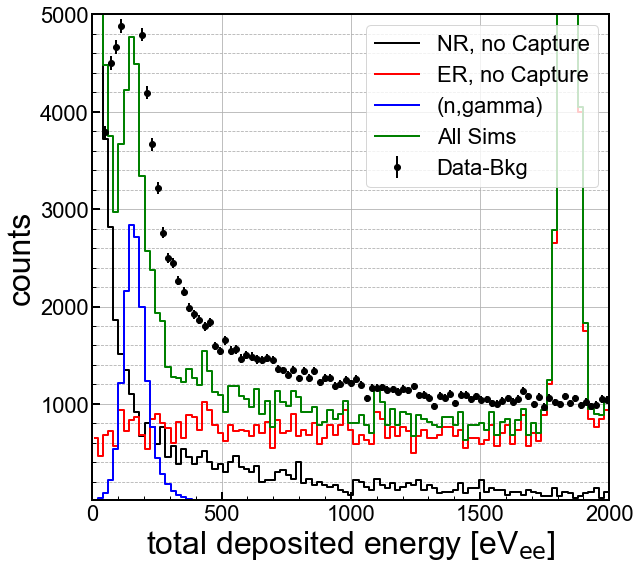

In [38]:
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ymin=1e1
#ymax=1e5
ymax=5e3
ax1.step(Ec,n_Eee_nr_nocap*livefac, where='mid',color='k', linestyle='-', \
         label='NR, no Capture', linewidth=2)

ax1.step(Ec,n_Eee_er_nocap*livefac, where='mid',color='r', linestyle='-', \
         label='ER, no Capture', linewidth=2)

ax1.step(Ec,n_Eee_ng*livefac*gesc_eff*fudge, where='mid',color='b', linestyle='-', \
         label='(n,gamma)', linewidth=2)

n_Eee_all = n_Eee_ng*livefac*gesc_eff*fudge+n_Eee_er_nocap*livefac+n_Eee_nr_nocap*livefac
ax1.step(Ec,n_Eee_all, where='mid',color='g', linestyle='-', \
         label='All Sims', linewidth=2)

err = np.sqrt(n_E_PuBe+n_E_Bkg)
ax1.errorbar(Ec,n_E_PuBe-n_E_Bkg,yerr=[err,err], marker='o', markersize=6, \
             ecolor='k',color='k', linestyle='none', label='Data-Bkg', linewidth=2)


ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0,Emax)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('total deposited energy [eV$_{\\mathrm{ee}}$]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()

# Looping on parameters
All of the steps above got us to the point of comparing spectra. Let's define a goodness of fit quantity and then build a loop to fit for various parameters like those describing yield and NR Fano factor.

In [291]:
import scipy
#Chisq goodness of fit of spec_meas to spec_pred, given predicted uncertainties unc_pred
def Chisq(spec_meas, spec_pred, unc_pred):
    return np.sum(((spec_meas-spec_pred)**2)/(unc_pred**2))

#Calculate the Poissonian likelihood of measuring spectrum spec_meas given the predicted spectrum spec_pred
def PoisLikelihood(spec_meas, spec_pred):
    PLi = [np.exp(-lamb)*(float(lamb)**n)/scipy.math.factorial(n) for n,lamb in zip(spec_meas,spec_pred)]
    return np.prod(PLi)

#Calculate the Log of Poissonian likelihood of measuring spectrum spec_meas given the predicted spectrum spec_pred
def PoisLogLikelihood(spec_meas, spec_pred):
    #PLLi = [ -n*lamb-np.log(float(scipy.math.factorial(n)))+n*np.log(float(lamb)) for n,lamb in zip(spec_meas,spec_pred)]
    #Stirlings approx for large n
    PLLi = [ -n*lamb-n*np.log(n)-n+n*np.log(lamb) for n,lamb in zip(spec_meas,spec_pred)]
    return np.sum(PLLi)

In [338]:
#Main fitting function which will be passed to the minimizer
#Inputs: NR yield, NR Fano factor
#Returns: Goodness of fit
def FittingFunc(params):
    Y=params[0]
    F_NR=params[1]
    fudge=params[2] # (n,gamma) rate normalization
    
    E_bins, N_er, N_nr, N_ng, N_PuBe, N_bkg = buildSpectra(Y, F_NR, fudge)
    
    thresh_bin=5
    
    spec_meas = (N_PuBe-N_bkg)[thresh_bin:]
    spec_pred = (N_er+N_nr+N_ng)[thresh_bin:]
    unc_pred = np.sqrt(spec_pred)
    
    #return PoisLogLikelihood(spec_meas,spec_pred)
    return Chisq(spec_meas, spec_pred, unc_pred)

#A redifinition of the fitting function for use with lmfit
def FittingFunc_v2(params,x=None):
    parvals = params.valuesdict()
    Y = parvals['Y']
    F_NR = parvals['F_NR']
    fudge = parvals['fudge']
    
    E_bins, N_er, N_nr, N_ng, N_PuBe, N_bkg = buildSpectra(Y, F_NR, fudge)
    
    thresh_bin=5
    
    spec_meas = (N_PuBe-N_bkg)[thresh_bin:]
    spec_pred = (N_er+N_nr+N_ng)[thresh_bin:]
    unc_pred = np.sqrt(spec_pred)
    
    #return PoisLogLikelihood(spec_meas,spec_pred)
    #return Chisq(spec_meas, spec_pred, unc_pred)
    return ((spec_meas-spec_pred)**2)/(unc_pred**2)

#Apply yield, resolution, efficiencies etc. to simulated data to get an instance of a simulated E_ee spectrum
def buildSpectra(Y, F_NR, fudge):
    #fudge = (n,gamma) rate normalization
    global evec_nr_nocap
    global evec_er_nocap
    global cdata
    
    global E_PuBe
    global E_Bkg
    
    ###############
    #Yield, Fano, Resolution
    ###############
    #NR, No capture
    E_nr_nocap_er = evec_nr_nocap + evec_nr_nocap*Y*(V/eps) #ER energy from NRs
    
    #Number of e/h pairs produced in each step
    N_nr_nocap = getNeh(E_nr_nocap_er,eps,F_NR)
    #get the total phonon energy
    Et_nr_nocap_step = N_nr_nocap*V + E_nr_nocap_er
    Et_nr_nocap = np.sum(Et_nr_nocap_step,1)
    Et_nr_nocap = getSmeared(Et_nr_nocap)#add resolution
    #convert to eVee scale by making the gamma assumption
    Eee_nr_nocap  = Et_nr_nocap/G_NTL

    #ER, No capture
    #Number of e/h pairs produced in each step
    E_er_nocap_er = evec_er_nocap #ER energy from ERs
    N_er_nocap = getNeh(E_er_nocap_er,eps,F)
    #get the total phonon energy
    Et_er_nocap_step = N_er_nocap*V + E_er_nocap_er
    Et_er_nocap = np.sum(Et_er_nocap_step,1)
    Et_er_nocap = getSmeared(Et_er_nocap)#add resolution
    #convert to eVee scale
    Eee_er_nocap  = Et_er_nocap/G_NTL
    
    #Convert Simulated n,gamma hits to eVee events
    #Prepare for the computation
    E_ng = cdata['E']
    dE_ng = cdata['delE']
    E_ng_er = E_ng*Y - (E_ng-dE_ng)*Y

    #simplistic gaussian model for charge to get width and mean correct
    N_ng = getNeh(E_ng_er,eps,F_NR)

    #get the total phonon energy
    Et_ng_step = N_ng*V + dE_ng
    Et_ng = np.sum(Et_ng_step,1)
    Et_ng = getSmeared(Et_ng) #add resolution

    #convert to eVee scale by making the gamma assumption
    Eee_ng  = Et_ng/G_NTL
    
    ###############
    #Binning
    ###############
    Emax = 2000 #eVee
    Ebins=np.linspace(0,Emax,101)

    #Measured
    n_E_PuBe,_ = np.histogram(E_PuBe*1e3,bins=Ebins)
    n_E_Bkg,_ = np.histogram(E_Bkg*1e3,bins=Ebins)

    #Simulated
    n_Eee_nr_nocap,_ = np.histogram(Eee_nr_nocap,bins=Ebins)
    n_Eee_er_nocap,_ = np.histogram(Eee_er_nocap,bins=Ebins)
    n_Eee_ng,_ = np.histogram(Eee_ng,bins=Ebins)

    ###############
    #Livetime, efficiencies, etc.
    ###############
    livefac = (60/3.6) #livetime fraction estimated from M. Fritts see email from March 22 2019.
    #he estimates 60 live hours of data
    #my simulation corresponds to 3.6 live hours if 1e6 neutrons/sec
    #or 1.8 live hours if 2e6 neutrons/second Pu/Be source. 
    
    livefac=livefac*2.1 #Systematic factor, tune to match out-of band rates
    
    gesc_eff = 0.9 #for Silicon have about a 10% chance of gammas interacting on the way out

    eff_pileup=0.965#http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/Run68_CutEff_2/
    eff_chisq=0.645#http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/Run68_CutEff_2/
    eff_trigburst=0.9887#http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/Run68_RateCut_pt2/
    eff_cuts=eff_pileup*eff_chisq*eff_trigburst
    
    #Apply these to the simulated data
    N_er = n_Eee_er_nocap*livefac*eff_cuts
    N_nr = n_Eee_nr_nocap*livefac*eff_cuts
    N_ng = n_Eee_ng*livefac*gesc_eff*eff_cuts*fudge
    N_PuBe = n_E_PuBe
    N_bkg = n_E_Bkg
    
    return (Ebins, N_er, N_nr, N_ng, N_PuBe, N_bkg)

In [337]:
#Integral of gaussian
def gausInt(mu, sigma, xlow, xhi):
    return 0.5*sp.erf((mu-xlow)/np.sqrt(2*sigma**2)) - 0.5*sp.erf((mu-xhi)/np.sqrt(2*sigma**2))

#Apply yield, resolution, efficiencies etc. to simulated data
# This version convolves fano and resolution functions with the spectrum, as opposed to drawing invividual values from 
# probability distributions for each hit.
# As such, this function returns the average spectra, which will not, in general, have integer counts
def buildAvgSpectra(Y, F_NR, fudge):
    global evec_nr_nocap
    global evec_er_nocap
    global cdata
    
    global E_PuBe
    global E_Bkg
    
    ###############
    #Binning
    ###############
    #E_ee binning
    Emax = 2000 #eVee
    Ebins=np.linspace(0,Emax,101)
    
    Nnr_max=5000
    N_binCtr_nr=np.linspace(0,Nnr_max,Nnr_max+1)
    N_count_nr_nocap=np.zeros(Nnr_max+1)
    
    ###############
    #Yield, Fano, Resolution
    ###############
    #NR, No capture
    #Average Neh in each event
    Navg_nr_nocap = np.sum(evec_nr_nocap,1)*Y/eps
    
    #Weighted spectrum of Number of e/h pairs produced
    for Navg in Navg_nr_nocap:
        N_count = gausInt(Navg, np.sqrt(F*Navg), N_binCtr_nr-0.5, N_binCtr_nr+0.5)
        N_count_nr_nocap = N_count_nr_nocap+N_count
    
    #Weighted spectrum of total phonon energy
    #TODO:
    Et_binCtr_nr = N_binCtr_nr

In [301]:
def plotSpectra(E_bins, N_er, N_nr, N_ng, N_PuBe, N_bkg):
    fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
    ax1 = axes

    Ec = (E_bins[:-1] + E_bins[1:]) / 2
    
    ymin=1e1
    #ymax=1e5
    ymax=7e3
    ax1.step(Ec,N_nr, where='mid',color='k', linestyle='-', \
             label='NR, no Capture', linewidth=2)

    ax1.step(Ec,N_er, where='mid',color='r', linestyle='-', \
             label='ER, no Capture', linewidth=2)

    ax1.step(Ec,N_ng, where='mid',color='b', linestyle='-', \
             label='(n,gamma)', linewidth=2)

    ax1.step(Ec,N_nr+N_er+N_ng, where='mid',color='g', linestyle='-', \
             label='All Sims', linewidth=2)

    err = np.sqrt(N_PuBe+N_bkg)
    ax1.errorbar(Ec,N_PuBe-N_bkg,yerr=[err,err], marker='o', markersize=6, \
                 ecolor='k',color='k', linestyle='none', label='Data-Bkg', linewidth=2)


    ax1.set_yscale('linear')
    #ax1.set_yscale('log')
    ax1.set_xlim(0,max(Ec))
    ax1.set_ylim(ymin,ymax)
    ax1.set_xlabel('total deposited energy [eV$_{\\mathrm{ee}}$]',**axis_font)
    ax1.set_ylabel('counts',**axis_font)
    ax1.grid(True)
    ax1.yaxis.grid(True,which='minor',linestyle='--')
    ax1.legend(loc=1,prop={'size':22})

    for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)

    plt.tight_layout()

In [305]:
#Struggling to get convergence, possibly because the spectral shapes are noisy due to random smearing effects
from scipy.optimize import minimize

x0=[0.8,3,8e-3]  #Y,F_NR,Fudge
#res = minimize(FittingFunc, x0, bounds=((0,1),(0,10),(0,1e-2)), method='COBYLA', options = {'rhobeg': 1} ) #
res = minimize(FittingFunc, x0, bounds=((0,1),(0,10),(0,1e-2)))

print(res)

      fun: 73596.27682321539
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.41730667e+11, -1.29437664e+11, -1.69133714e+11])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 100
      nit: 3
   status: 0
  success: True
        x: array([0.79999911, 3.00000572, 0.00799932])


In [319]:
# Try with lmfit
import lmfit

# create a set of Parameters
params = lmfit.Parameters()
params.add('Y', value=0.8, min=0, max=1)
params.add('F_NR', value=3, min=0, max=10)
params.add('fudge', value=8e-3, vary=False, min=0, max=1e-1)

# do fit, here with leastsq model
minner = lmfit.Minimizer(FittingFunc_v2, params, epsfcn=0.1)
result = minner.minimize()
print(lmfit.fit_report(result))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 94
    # variables        = 2
    chi-square         = 4.4350e+08
    reduced chi-square = 4820657.66
    Akaike info crit   = 1448.48998
    Bayesian info crit = 1453.57657
[[Variables]]
    Y:      0.83217085 +/- 0.09075345 (10.91%) (init = 0.8)
    F_NR:   2.76007770 +/- 0.62753243 (22.74%) (init = 3)
    fudge:  0.008 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(Y, F_NR) = -0.351


In [293]:
Ys=np.linspace(0.01,1,10)
Fs=np.linspace(0.01,5,10)
X,Y=np.meshgrid(Ys,Fs)
Z=np.zeros_like(X)

for i,Yi in enumerate(Ys):
    for j,Fi in enumerate(Fs):
        Z[j,i]=FittingFunc([Yi,Fi,5e-3])

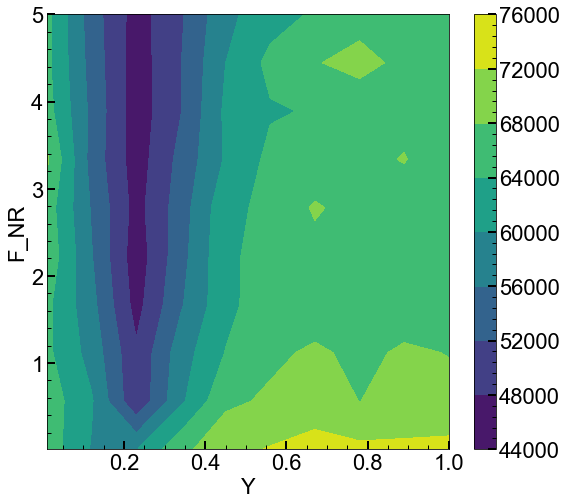

In [294]:
from matplotlib import ticker
import matplotlib.colors as colors
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes
#cs=ax1.contourf(X,Y,Z,norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
cs=ax1.contourf(X,Y,Z)
ax1.set_xlabel('Y')
ax1.set_ylabel('F_NR')
plt.colorbar(cs)

In [295]:
print(Z.min(),np.where(Z==Z.min()))
print(X[np.where(Z==Z.min())],Y[np.where(Z==Z.min())],Z[np.where(Z==Z.min())])

45698.299330868555 (array([4]), array([2]))
[0.23] [2.22777778] [45698.29933087]


Chisq:  4.64e+04
PoisLog:  -3.59e+08


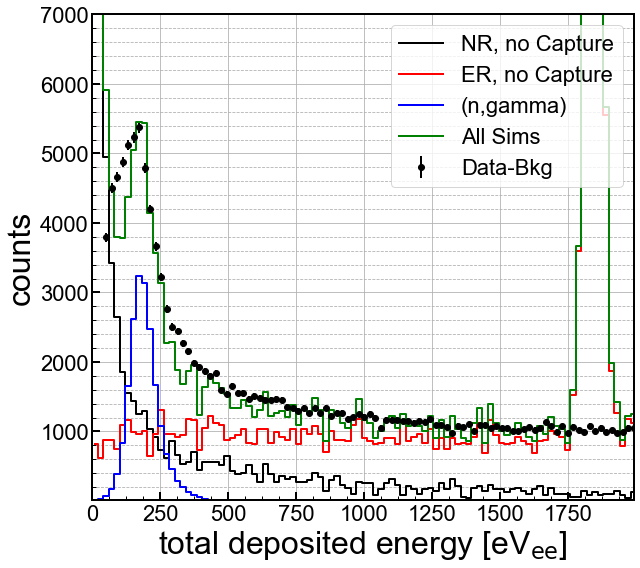

In [302]:
E_bins, N_er, N_nr, N_ng, N_PuBe, N_bkg = buildSpectra(0.23,2.228,5e-3)#Y, F_NR, fudge

thresh_bin=5
spec_meas = (N_PuBe-N_bkg)[thresh_bin:]
spec_pred = (N_er+N_nr+N_ng)[thresh_bin:]
unc_pred = np.sqrt(spec_pred)

print("Chisq: ","{:.2e}".format(Chisq(spec_meas, spec_pred, unc_pred)))
print("PoisLog: ","{:.2e}".format(PoisLogLikelihood(spec_meas, spec_pred)))
plotSpectra(E_bins, N_er, N_nr, N_ng, N_PuBe, N_bkg)

# Integral Method
As discussed in the Damic NR Yield paper, another approach is to compare the integrals of the simulated and measured spectra to obtain Y. This does not rely on a parameterized yield function. However, applying resolution and Fano effects are tricky.

TODO: Where does Fano fit in here?

How to account for multiple recoils in capture events?

Steps
1. Calculate normalization factor so Simulated ER spectrum agrees with Measured, bkg-subtracted spectrum above ~1.75 keV. We'll use the same factor for simulated NRs too. Somehow normalize (n,gamma) spectrum as well.
2. Starting at the high energy end, count the number of measured events above electron-equivalent energy Ee_star, Ne_meas(Ee>Ee_star). Then find the nuclear recoil energy, Er_star such that: Ner_sim(Ee>Ee_star) + Nnr_sim(Er>Er_star)= Ne_meas(Ee>Ee_star). This will result in a set of points (Er_star,Ee_star) which define Y.
3. Apply the calculated Y to the Simulated spectra, then smear it with the detector resolution, and use Y to convert back to nuclear recoil energies. Finally, repeat the steps in 2) to obtain Y from the smeared Simulated spectrum.
4. Repeat the above steps, starting with the original unsmeared spectrum and the new Y.
5. Continue this all until Y converges.